<a href="https://colab.research.google.com/github/pea-sys/Til/blob/master/PyTorch_Tutorials_WritingCustomDatasets%2CDataLoaders_and_Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Original](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
# WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS
機械学習の問題を解決するための多くの努力は、データの準備に費やされます。 PyTorchは、コードを読みやすくするために、データの読み込みを簡単にできるようにする多くのツールを提供しています。このチュートリアルでは、自明ではないデータセットからデータをロードして前処理/拡張する方法を説明します。

このチュートリアルを実行するには、次のパッケージがインストールされていることを確認してください。

* scikit-image：画像IOおよび変換用
* pandas：CSV解析を簡単にするため

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


扱うデータセットは、顔のポーズです。つまり、顔には次のように注釈が付けられます。  

[ここ](https://download.pytorch.org/tutorial/faces.zip)からデータセットをダウンロードして、画像が「data / faces /」という名前のディレクトリにあるようにします。このデータセットは、「顔」としてタグ付けされたイメージネットからのいくつかの画像に優れたdlibの姿勢推定を適用することで実際に生成されました。


In [2]:
import google.colab
import googleapiclient.discovery
import googleapiclient.http
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')
def gdrive_dl(filename):
  upload_filename = filename

  file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')

  # ファイル ID を取得します。
  file_id = None
  for file in file_list:
    if file.get('name') == upload_filename:
      file_id = file.get('id')
      break

  if file_id is None:
    # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
    print(upload_filename + ' が見つかりません.')
  else:
    # colab 環境へファイルをアップロードします。
    with open(upload_filename, 'wb') as f:
      request = drive_service.files().get_media(fileId=file_id)
      media = googleapiclient.http.MediaIoBaseDownload(f, request)

      done = False
      while not done:
        progress_status, done = media.next_chunk()
        print(100*progress_status.progress(), end="")
        print("%完了")

    print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')

gdrive_dl('faces.zip')

100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


In [0]:
import zipfile
zip = zipfile.ZipFile("faces.zip")
zip.extractall("data/")  # ZIPを解凍
zip.close()  # ZIPファイルをクローズ

データセットには、次のような注釈付きのcsvファイルが付属しています。


```
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

```
CSVをすばやく読み、Nがランドマークの数である（N、2）配列で注釈を取得しましょう。


In [4]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


画像とそのランドマークを表示する簡単なヘルパー関数を作成し、それを使用してサンプルを表示しましょう。

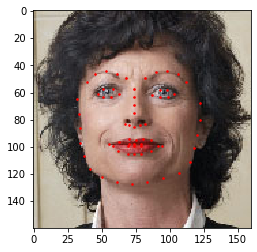

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

# Dataset class
torch.utils.data.Datasetは、データセットを表す抽象クラスです。カスタムデータセットはデータセットを継承し、次のメソッドをオーバーライドする必要があります。

__len__ len（dataset）がデータセットのサイズを返すようにします。
__getitem__は、i番目のサンプルを取得するためにdataset [i]を使用できるようにインデックス付けをサポートします
顔のランドマークデータセットのデータセットクラスを作成しましょう。 __init__でcsvを読み取りますが、画像の読み取りは__getitem__に任せます。すべての画像が一度にメモリに保存されるのではなく、必要に応じて読み取られるため、これはメモリ効率に優れています。

データセットのサンプルは、dict {'image'：image、 'landmarks'：landmarks}です。データセットはオプションの引数変換を使用するため、必要な処理をサンプルに適用できます。変換の有用性については、次のセクションで説明します。

In [0]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

このクラスをインスタンス化し、データサンプルを反復処理してみましょう。最初の4つのサンプルのサイズを印刷し、ランドマークを表示します。

0 (324, 215, 3) (68, 2)


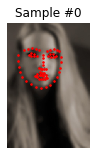

1 (500, 333, 3) (68, 2)


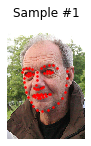

2 (250, 258, 3) (68, 2)


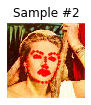

3 (434, 290, 3) (68, 2)


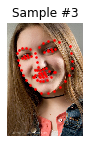

In [7]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

# Transforms
上記からわかる問題の1つは、サンプルのサイズが同じではないことです。ほとんどのニューラルネットワークでは、固定サイズの画像が必要です。したがって、事前処理コードを作成する必要があります。 3つの変換を作成しましょう。

* 再スケーリング：画像をスケーリングする
* RandomCrop：画像からランダムに切り抜きます。これはデータ拡張です。
* ToTensor：numpyイメージをトーチイメージに変換します（軸を交換する必要があります）。

トランスフォームのパラメーターが呼び出されるたびに渡される必要がないように、単純な関数ではなく呼び出し可能なクラスとしてそれらを記述します。そのためには、__ call__メソッドを実装し、必要に応じて__init__メソッドを実装するだけです。その後、次のような変換を使用できます。



```
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```




これらの変換を画像とランドマークの両方に適用する方法を以下で観察します。

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

# Compose transforms
次に、サンプルに変換を適用します。

画像の短辺を256に再スケーリングし、そこからサイズ224の正方形をランダムに切り取りたいとします。つまり、RescaleおよびRandomCrop変換を作成します。 torchvision.transforms.Composeは、これを行うことができる単純な呼び出し可能なクラスです。

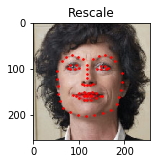

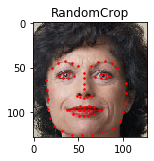

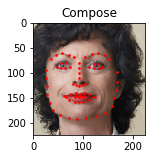

In [9]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

# Iterating through the dataset

これをすべてまとめて、変換が変換されたデータセットを作成しましょう。要約すると、このデータセットがサンプリングされるたびに：

* 画像はその場でファイルから読み込まれます
* 変換は読み取り画像に適用されます
* 変換の1つがランダムであるため、サンプリング時にデータが増加します


前と同様に、範囲内のfor iループを使用して、作成されたデータセットを反復処理できます。

In [10]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


ただし、単純なforループを使用してデータを反復処理することにより、多くの機能が失われています。特に、次のものを見逃しています：

データのバッチ処理
データのシャッフル
マルチプロセッシングワーカーを使用してデータを並列に読み込みます。
torch.utils.data.DataLoaderは、これらすべての機能を提供するイテレーターです。以下で使用するパラメーターは明確にする必要があります。関心のあるパラメーターの1つはcollat​​e_fnです。 collat​​e_fnを使用して、サンプルのバッチ処理の正確性を指定できます。ただし、ほとんどのユースケースでは、デフォルトの照合は正常に機能するはずです。

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


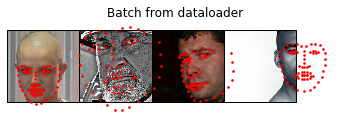

In [11]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break